In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re

import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

In [2]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/Fake New Detection files/train.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv(file_path)
df

,ID,title,text,subject,date,class
0,0.0,#AfterTrumpImplodes Hashtag Hilariously Imagi...,What will the world be like post-Donald Trump?...,News,5-Aug-16,0.0
1,1.0,#BlackLivesMatter Leader To Run For Mayor Of ...,The police shooting of black teen Michael Brow...,News,4-Feb-16,0.0
2,2.0,#BringBackObama Hashtag Blows Up On Twitter A...,The six months since President Donald Trump wa...,News,13-Jul-17,0.0
3,3.0,#FreeChrisChristie: Twitter Reacts To The ‘Ho...,"Last Friday, New Jersey Governor Chris Christi...",News,2-Mar-16,0.0
4,4.0,#MakeAmericaBrannigan: Futurama Voice Actor R...,"The incredibly talented voice actor, Billy Wes...",News,13-Aug-16,0.0
...,...,...,...,...,...,...
44914,NaN,NaN,NaN,NaN,NaN,NaN
44915,NaN,NaN,NaN,NaN,NaN,NaN
44916,NaN,NaN,NaN,NaN,NaN,NaN
44917,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df = df.drop_duplicates()
df

,ID,title,text,subject,date,class
0,0.0,#AfterTrumpImplodes Hashtag Hilariously Imagi...,What will the world be like post-Donald Trump?...,News,5-Aug-16,0.0
1,1.0,#BlackLivesMatter Leader To Run For Mayor Of ...,The police shooting of black teen Michael Brow...,News,4-Feb-16,0.0
2,2.0,#BringBackObama Hashtag Blows Up On Twitter A...,The six months since President Donald Trump wa...,News,13-Jul-17,0.0
3,3.0,#FreeChrisChristie: Twitter Reacts To The ‘Ho...,"Last Friday, New Jersey Governor Chris Christi...",News,2-Mar-16,0.0
4,4.0,#MakeAmericaBrannigan: Futurama Voice Actor R...,"The incredibly talented voice actor, Billy Wes...",News,13-Aug-16,0.0
...,...,...,...,...,...,...
40423,40402.0,U.S. judge to lift house arrest for former Tru...,WASHINGTON (Reuters) - A U.S. District Court j...,politicsNews,15-Dec-17,1.0
40424,40403.0,"U.S. judge to look into Giuliani, Mukasey's ro...",NEW YORK (Reuters) - A U.S. judge said he will...,politicsNews,4-Apr-17,1.0
40425,40404.0,U.S. judge to mull release of Trump video test...,SAN DIEGO (Reuters) - U.S. District Judge Gonz...,politicsNews,13-Jul-16,1.0
40426,40405.0,U.S. judge to review FBI's Clinton emails sear...,NEW YORK (Reuters) - A U.S. judge on Tuesday d...,politicsNews,13-Dec-16,1.0


In [5]:
df = df.dropna(subset=["class"])
df

,ID,title,text,subject,date,class
0,0.0,#AfterTrumpImplodes Hashtag Hilariously Imagi...,What will the world be like post-Donald Trump?...,News,5-Aug-16,0.0
1,1.0,#BlackLivesMatter Leader To Run For Mayor Of ...,The police shooting of black teen Michael Brow...,News,4-Feb-16,0.0
2,2.0,#BringBackObama Hashtag Blows Up On Twitter A...,The six months since President Donald Trump wa...,News,13-Jul-17,0.0
3,3.0,#FreeChrisChristie: Twitter Reacts To The ‘Ho...,"Last Friday, New Jersey Governor Chris Christi...",News,2-Mar-16,0.0
4,4.0,#MakeAmericaBrannigan: Futurama Voice Actor R...,"The incredibly talented voice actor, Billy Wes...",News,13-Aug-16,0.0
...,...,...,...,...,...,...
40422,40401.0,U.S. judge to consider objection to Trump Univ...,NEW YORK (Reuters) - A U.S. judge will hear ar...,politicsNews,29-Mar-17,1.0
40423,40402.0,U.S. judge to lift house arrest for former Tru...,WASHINGTON (Reuters) - A U.S. District Court j...,politicsNews,15-Dec-17,1.0
40424,40403.0,"U.S. judge to look into Giuliani, Mukasey's ro...",NEW YORK (Reuters) - A U.S. judge said he will...,politicsNews,4-Apr-17,1.0
40425,40404.0,U.S. judge to mull release of Trump video test...,SAN DIEGO (Reuters) - U.S. District Judge Gonz...,politicsNews,13-Jul-16,1.0


In [6]:
df.dtypes

ID         float64
title       object
text        object
subject     object
date        object
class      float64
dtype: object

In [7]:
df.isnull().sum()

ID         21
title       0
text        0
subject     0
date        0
class       0
dtype: int64

In [8]:
df = df.drop(columns=["ID"])
df

,title,text,subject,date,class
0,#AfterTrumpImplodes Hashtag Hilariously Imagi...,What will the world be like post-Donald Trump?...,News,5-Aug-16,0.0
1,#BlackLivesMatter Leader To Run For Mayor Of ...,The police shooting of black teen Michael Brow...,News,4-Feb-16,0.0
2,#BringBackObama Hashtag Blows Up On Twitter A...,The six months since President Donald Trump wa...,News,13-Jul-17,0.0
3,#FreeChrisChristie: Twitter Reacts To The ‘Ho...,"Last Friday, New Jersey Governor Chris Christi...",News,2-Mar-16,0.0
4,#MakeAmericaBrannigan: Futurama Voice Actor R...,"The incredibly talented voice actor, Billy Wes...",News,13-Aug-16,0.0
...,...,...,...,...,...
40422,U.S. judge to consider objection to Trump Univ...,NEW YORK (Reuters) - A U.S. judge will hear ar...,politicsNews,29-Mar-17,1.0
40423,U.S. judge to lift house arrest for former Tru...,WASHINGTON (Reuters) - A U.S. District Court j...,politicsNews,15-Dec-17,1.0
40424,"U.S. judge to look into Giuliani, Mukasey's ro...",NEW YORK (Reuters) - A U.S. judge said he will...,politicsNews,4-Apr-17,1.0
40425,U.S. judge to mull release of Trump video test...,SAN DIEGO (Reuters) - U.S. District Judge Gonz...,politicsNews,13-Jul-16,1.0


<ipython-input-9-81887aae92a3>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=df, palette=['g','r'])


<Axes: xlabel='class', ylabel='count'>

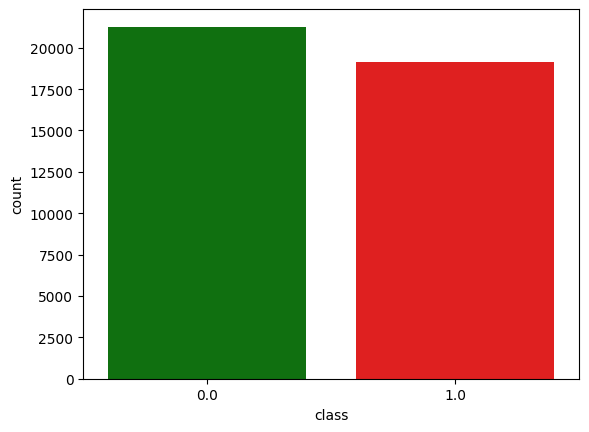

In [9]:
sns.countplot(x='class', data=df, palette=['g','r'])

In [10]:
print(df['subject'].unique())

['News'
 ' claimed that hundreds of alternative media websites were producing  fake news  and  conspiracy  stories and therefore were unreliable as information sources. It wasn t long before the establishment began referencing these politicized lists'
 'politicsNews' 'worldnews' 'politics' 'left-news' 'US_News' 'Middle-east'
 'Government News'
 ' Karl Marx is either a villain or a hero of social engineering'
 ' a future nuclear family'
 ' state systems with outsized pretensions to power have reacted to their environments in two ways. The first strategy'
 ' of which Soros is a major financier.Mercy Corps: Vis a vis the Arab-Israeli conflict'
 ' the defense industry' ' and so is Mr. Katzenbach'
 ' Politics According to the Bible and (with Barry Asmus) The Poverty of Nations: A Sustainable Solution.Via: Townhall"'
 ' high taxes'
 ' fell 5.6 percent Monday. Wynn Resortsslipped 1.2 percent. Las Vegas Sands fell as much as 2.1 percent before closing higher.   LIVE DRILL    Las Vegas has been

In [11]:
df['subject'] = df['subject'].apply(lambda x: 'politics' if x == 'politicsNews' else x)
df['subject'].unique()

array(['News',
       ' claimed that hundreds of alternative media websites were producing  fake news  and  conspiracy  stories and therefore were unreliable as information sources. It wasn t long before the establishment began referencing these politicized lists',
       'politics', 'worldnews', 'left-news', 'US_News', 'Middle-east',
       'Government News',
       ' Karl Marx is either a villain or a hero of social engineering',
       ' a future nuclear family',
       ' state systems with outsized pretensions to power have reacted to their environments in two ways. The first strategy',
       ' of which Soros is a major financier.Mercy Corps: Vis a vis the Arab-Israeli conflict',
       ' the defense industry', ' and so is Mr. Katzenbach',
       ' Politics According to the Bible and (with Barry Asmus) The Poverty of Nations: A Sustainable Solution.Via: Townhall"',
       ' high taxes',
       ' fell 5.6 percent Monday. Wynn Resortsslipped 1.2 percent. Las Vegas Sands fell as much

In [12]:
politics_news = df[df['subject'] == 'politics']
left_news = df[df['subject'] == 'left-news']

# Display sample titles and text for comparison
print(politics_news[['title', 'text']].head())
print(left_news[['title', 'text']].head())


                                                  title  \
9051  "It would be huge": U.S. border town confronts...   
9052  "Make Republicans Whole Again!" A divided part...   
9057  #AnyoneButHillary: NEW POLL Shows Bernie Suppo...   
9059  #Austin: Fights Break Out Between Police and S...   
9061  #Berkeley CRAZY! RIOTERS CHASE And Beat People...   

                                                   text  
9051  NOGALES, Arizona (Reuters) - For up to 16 hour...  
9052  CLEVELAND (Reuters) - Ted Cruz was recounting ...  
9057  Hillary may find out she needs more than black...  
9059  Commies carrying flags fought with the Austin ...  
9061  Is anyone else thinking what we re thinking ab...  
                                                  title  \
9058  #AnyoneButHillary: NEW POLL Shows Bernie Suppo...   
9060  #Austin: Fights Break Out Between Police and S...   
9062  #Berkeley CRAZY! RIOTERS CHASE And Beat People...   
9064  #Berkeley IRONY ALERT! ANARCHISTS LOOT STARBUC...   
90

In [13]:
df['subject'] = df['subject'].apply(lambda x: 'politics' if x == 'left-news' else x)
print(df['subject'].unique())

['News'
 ' claimed that hundreds of alternative media websites were producing  fake news  and  conspiracy  stories and therefore were unreliable as information sources. It wasn t long before the establishment began referencing these politicized lists'
 'politics' 'worldnews' 'US_News' 'Middle-east' 'Government News'
 ' Karl Marx is either a villain or a hero of social engineering'
 ' a future nuclear family'
 ' state systems with outsized pretensions to power have reacted to their environments in two ways. The first strategy'
 ' of which Soros is a major financier.Mercy Corps: Vis a vis the Arab-Israeli conflict'
 ' the defense industry' ' and so is Mr. Katzenbach'
 ' Politics According to the Bible and (with Barry Asmus) The Poverty of Nations: A Sustainable Solution.Via: Townhall"'
 ' high taxes'
 ' fell 5.6 percent Monday. Wynn Resortsslipped 1.2 percent. Las Vegas Sands fell as much as 2.1 percent before closing higher.   LIVE DRILL    Las Vegas has been at the forefront of active 

In [14]:
def clean_date(date):
    try:
        return pd.to_datetime(date, format='%d-%b-%y')
    except (ValueError, TypeError):
        return np.nan

In [15]:
df['date'] = df['date'].apply(clean_date)
df = df.dropna(subset=['date'])

In [16]:
df = df.drop_duplicates(keep='first')
df

,title,text,subject,date,class
0,#AfterTrumpImplodes Hashtag Hilariously Imagi...,What will the world be like post-Donald Trump?...,News,2016-08-05,0.0
1,#BlackLivesMatter Leader To Run For Mayor Of ...,The police shooting of black teen Michael Brow...,News,2016-02-04,0.0
2,#BringBackObama Hashtag Blows Up On Twitter A...,The six months since President Donald Trump wa...,News,2017-07-13,0.0
3,#FreeChrisChristie: Twitter Reacts To The ‘Ho...,"Last Friday, New Jersey Governor Chris Christi...",News,2016-03-02,0.0
4,#MakeAmericaBrannigan: Futurama Voice Actor R...,"The incredibly talented voice actor, Billy Wes...",News,2016-08-13,0.0
...,...,...,...,...,...
40422,U.S. judge to consider objection to Trump Univ...,NEW YORK (Reuters) - A U.S. judge will hear ar...,politics,2017-03-29,1.0
40423,U.S. judge to lift house arrest for former Tru...,WASHINGTON (Reuters) - A U.S. District Court j...,politics,2017-12-15,1.0
40424,"U.S. judge to look into Giuliani, Mukasey's ro...",NEW YORK (Reuters) - A U.S. judge said he will...,politics,2017-04-04,1.0
40425,U.S. judge to mull release of Trump video test...,SAN DIEGO (Reuters) - U.S. District Judge Gonz...,politics,2016-07-13,1.0


In [17]:
print(df['subject'].unique())

['News' 'politics' 'worldnews' 'US_News' 'Middle-east' 'Government News']


In [18]:
world_news = df[df['subject'] == 'worldnews']
US_news = df[df['subject'] == 'US_News']
Middle_east = df[df['subject'] == 'Middle-east']
gov = df[df['subject'] == 'Government News']

# Display sample titles and text for comparison
print(world_news[['title', 'text']].head())
print("------------------")
print(US_news[['title', 'text']].head())
print("------------------")
print(Middle_east[['title', 'text']].head())
print("------------------")
print(gov[['title', 'text']].head())

                                                  title  \
9053  "Nobody stood with the Kurds" says bitter Barzani   
9054  "The people have spoken," says Zimbabwe's new ...   
9055  "The people have spoken," Zimbabwe's Mnangagwa...   
9056  "You are the light" - Philippines' Duterte cro...   
9502    13 killed in gang battles in two Mexican states   

                                                   text  
9053  BAGHDAD (Reuters) - Kurdish leader Masoud Barz...  
9054  HARARE (Reuters) - Zimbabwe s new leader Emmer...  
9055  HARARE (Reuters) - Zimbabwe s former vice pres...  
9056  MANILA (Reuters) - President Rodrigo Duterte c...  
9502  MEXICO CITY (Reuters) - At least 13 people wer...  
------------------
                                                  title  \
9088  #CNNBlackmail Trending as Network Blackmails T...   
9104                 #FakeNews Made By Mainstream Media   
9115                      #Hashtag Hell & The Fake Left   
9157  (Don’t Hold The Press) Jeb Bush Endo

There are also duplicates in text and title

In [19]:
df = df.drop_duplicates(subset=['text'], keep='first')
df = df.drop_duplicates(subset=['title'], keep='first')
df

,title,text,subject,date,class
0,#AfterTrumpImplodes Hashtag Hilariously Imagi...,What will the world be like post-Donald Trump?...,News,2016-08-05,0.0
1,#BlackLivesMatter Leader To Run For Mayor Of ...,The police shooting of black teen Michael Brow...,News,2016-02-04,0.0
2,#BringBackObama Hashtag Blows Up On Twitter A...,The six months since President Donald Trump wa...,News,2017-07-13,0.0
3,#FreeChrisChristie: Twitter Reacts To The ‘Ho...,"Last Friday, New Jersey Governor Chris Christi...",News,2016-03-02,0.0
4,#MakeAmericaBrannigan: Futurama Voice Actor R...,"The incredibly talented voice actor, Billy Wes...",News,2016-08-13,0.0
...,...,...,...,...,...
40422,U.S. judge to consider objection to Trump Univ...,NEW YORK (Reuters) - A U.S. judge will hear ar...,politics,2017-03-29,1.0
40423,U.S. judge to lift house arrest for former Tru...,WASHINGTON (Reuters) - A U.S. District Court j...,politics,2017-12-15,1.0
40424,"U.S. judge to look into Giuliani, Mukasey's ro...",NEW YORK (Reuters) - A U.S. judge said he will...,politics,2017-04-04,1.0
40425,U.S. judge to mull release of Trump video test...,SAN DIEGO (Reuters) - U.S. District Judge Gonz...,politics,2016-07-13,1.0


In [20]:
min_date = df['date'].min()
max_date = df['date'].max()

print(min_date)
print(max_date)

2015-03-31 00:00:00
2018-02-19 00:00:00


In [21]:
date_range = max_date - min_date
date_range

Timedelta('1056 days 00:00:00')

We can classify the date to 16 time class and each class has 66 values.

In [22]:
date_ranges = []
curr_start_date = min_date
range_duration = pd.Timedelta(days=66)

while curr_start_date < max_date:
    curr_end_date = curr_start_date + range_duration
    if curr_end_date > max_date:
      curr_end_date = max_date
    date_ranges.append((curr_start_date, curr_end_date))
    curr_start_date = curr_end_date

date_ranges

[(Timestamp('2015-03-31 00:00:00'), Timestamp('2015-06-05 00:00:00')),
 (Timestamp('2015-06-05 00:00:00'), Timestamp('2015-08-10 00:00:00')),
 (Timestamp('2015-08-10 00:00:00'), Timestamp('2015-10-15 00:00:00')),
 (Timestamp('2015-10-15 00:00:00'), Timestamp('2015-12-20 00:00:00')),
 (Timestamp('2015-12-20 00:00:00'), Timestamp('2016-02-24 00:00:00')),
 (Timestamp('2016-02-24 00:00:00'), Timestamp('2016-04-30 00:00:00')),
 (Timestamp('2016-04-30 00:00:00'), Timestamp('2016-07-05 00:00:00')),
 (Timestamp('2016-07-05 00:00:00'), Timestamp('2016-09-09 00:00:00')),
 (Timestamp('2016-09-09 00:00:00'), Timestamp('2016-11-14 00:00:00')),
 (Timestamp('2016-11-14 00:00:00'), Timestamp('2017-01-19 00:00:00')),
 (Timestamp('2017-01-19 00:00:00'), Timestamp('2017-03-26 00:00:00')),
 (Timestamp('2017-03-26 00:00:00'), Timestamp('2017-05-31 00:00:00')),
 (Timestamp('2017-05-31 00:00:00'), Timestamp('2017-08-05 00:00:00')),
 (Timestamp('2017-08-05 00:00:00'), Timestamp('2017-10-10 00:00:00')),
 (Time

In [23]:
def assign_date_range(date):
    for i, (start, end) in enumerate(date_ranges):
        if start <= date <= end:
            return i
    return 'What?'

In [24]:
df['date_range'] = df['date'].apply(assign_date_range)
df

,title,text,subject,date,class,date_range
0,#AfterTrumpImplodes Hashtag Hilariously Imagi...,What will the world be like post-Donald Trump?...,News,2016-08-05,0.0,7
1,#BlackLivesMatter Leader To Run For Mayor Of ...,The police shooting of black teen Michael Brow...,News,2016-02-04,0.0,4
2,#BringBackObama Hashtag Blows Up On Twitter A...,The six months since President Donald Trump wa...,News,2017-07-13,0.0,12
3,#FreeChrisChristie: Twitter Reacts To The ‘Ho...,"Last Friday, New Jersey Governor Chris Christi...",News,2016-03-02,0.0,5
4,#MakeAmericaBrannigan: Futurama Voice Actor R...,"The incredibly talented voice actor, Billy Wes...",News,2016-08-13,0.0,7
...,...,...,...,...,...,...
40422,U.S. judge to consider objection to Trump Univ...,NEW YORK (Reuters) - A U.S. judge will hear ar...,politics,2017-03-29,1.0,11
40423,U.S. judge to lift house arrest for former Tru...,WASHINGTON (Reuters) - A U.S. District Court j...,politics,2017-12-15,1.0,14
40424,"U.S. judge to look into Giuliani, Mukasey's ro...",NEW YORK (Reuters) - A U.S. judge said he will...,politics,2017-04-04,1.0,11
40425,U.S. judge to mull release of Trump video test...,SAN DIEGO (Reuters) - U.S. District Judge Gonz...,politics,2016-07-13,1.0,7


In [25]:
df['date_range'].value_counts()

date_range
14    6655
13    4894
10    2806
5     2588
8     2321
9     2306
6     2301
11    2258
12    2209
4     2142
7     2007
15     931
3      373
1      341
2      317
0      314
Name: count, dtype: int64

In [26]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    ps = PorterStemmer()
    tokens = [ps.stem(word) for word in tokens]
    return ' '.join(tokens)

In [27]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
df['title'] = df['title'].apply(preprocess_text)
df['text'] = df['text'].apply(preprocess_text)

In [29]:
df['title_length'] = df['title'].apply(lambda x: len(x.split()))
df['text_length'] = df['text'].apply(lambda x: len(x.split()))

In [30]:
le = LabelEncoder()
df['subject'] = le.fit_transform(df['subject'])

In [31]:
df['combined_title_and_text'] = df['title'] + ' ' + df['text']

In [32]:
df['combined_title_and_text'] = df['combined_title_and_text'].astype(str)

In [33]:
X = df[['combined_title_and_text', 'subject', 'date_range']]
y = df['class']

In [34]:
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=5000, ngram_range=(1, 2)), 'combined_title_and_text'),
        ('others', OneHotEncoder(handle_unknown='ignore'), ['subject', 'date_range'])
    ],
    remainder='passthrough'
)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [36]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train['combined_title_and_text'])
X_test_tfidf = vectorizer.transform(X_test['combined_title_and_text'])

In [37]:
model_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=1000, class_weight='balanced'))
])

model_gb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(n_estimators=1000))
])

model_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier())
])

In [38]:
model_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text',
                                                  TfidfVectorizer(max_features=5000,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'combined_title_and_text'),
                                                 ('others',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['subject', 'date_range'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000))])

In [39]:
model_gb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text',
                                                  TfidfVectorizer(max_features=5000,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'combined_title_and_text'),
                                                 ('others',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['subject', 'date_range'])])),
                ('classifier', GradientBoostingClassifier(n_estimators=1000))])

In [40]:
model_xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text',
                                                  TfidfVectorizer(max_features=5000,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'combined_title_and_text'),
                                                 ('others',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['subject', 'date_range'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, c...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [41]:
columns=['RandomForestClassifier','GradientBoostingClassifier','XGBoost']
result1=[]
result2=[]
result3=[]

In [42]:
def cal(model):
    y_pred = model.predict(X_test)
    acc=accuracy_score(y_test, y_pred)
    CR=classification_report(y_test, y_pred)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    MeanCV=np.mean(cv_scores)

    result1.append(acc)
    result2.append(cv_scores)
    result3.append(MeanCV)

    print(model)
    print('Accuracy: ', acc)
    print('Classification Report:\n', CR)
    print(f"Cross-Validation Scores: {cv_scores}")
    print(f"Mean CV Score: {np.mean(cv_scores)}")

In [43]:
cal(model_rf)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text',
                                                  TfidfVectorizer(max_features=5000,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'combined_title_and_text'),
                                                 ('others',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['subject', 'date_range'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000))])
Accuracy:  0.998274374460742
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00

In [44]:
cal(model_gb)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text',
                                                  TfidfVectorizer(max_features=5000,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'combined_title_and_text'),
                                                 ('others',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['subject', 'date_range'])])),
                ('classifier', GradientBoostingClassifier(n_estimators=1000))])
Accuracy:  0.9962611446649411
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1610
         1.0       1.00      1.00      1.00   

In [45]:
cal(model_xgb)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text',
                                                  TfidfVectorizer(max_features=5000,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'combined_title_and_text'),
                                                 ('others',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['subject', 'date_range'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, c...
                               feature_types=None, gamma=None, grow_policy=None,
                               importan

In [46]:
testing_df = pd.read_csv('/content/test.csv')
testing_df

,ID,title,text,subject,date
0,1,U.S. judge presses Trump administration on Dre...,NEW YORK (Reuters) - A U.S. judge on Thursday ...,politicsNews,21-Sep-17
1,2,U.S. judge questions government on Trump's lat...,"GREENBELT, Md. (Reuters) - A U.S. judge on Mon...",politicsNews,16-Oct-17
2,3,U.S. judge questions states seeking to restore...,SAN FRANCISCO (Reuters) - A U.S. judge on Mond...,politicsNews,23-Oct-17
3,4,U.S. judge refuses to halt New York nuclear po...,NEW YORK (Reuters) - A federal judge on Tuesda...,politicsNews,25-Jul-17
4,5,U.S. judge rejects bid to dismiss Indonesian i...,BOSTON (Reuters) - A federal judge on Wednesda...,worldnews,25-Oct-17
...,...,...,...,...,...
4491,4492,Zuckerberg again rejects claims of Facebook im...,NEW YORK (Reuters) - Facebook Inc chief execut...,politicsNews,13-Nov-16
4492,4493,Zuma given November 30 deadline ahead of South...,JOHANNESBURG (Reuters) - South Africa s Nation...,worldnews,20-Oct-17
4493,4494,Zuma says South Africa and Morocco will resume...,JOHANNESBURG (Reuters) - South Africa and Moro...,worldnews,3-Dec-17
4494,4495,Zuma says South Africa's free higher education...,JOHANNESBURG (Reuters) - South Africa s govern...,worldnews,16-Dec-17


In [47]:
testing_df['subject'] = testing_df['subject'].apply(lambda x: 'politics' if x == 'politicsNews' else x)
testing_df['subject'] = testing_df['subject'].apply(lambda x: 'politics' if x == 'left-news' else x)
testing_df['date'] = testing_df['date'].apply(clean_date)
testing_df['date_range'] = testing_df['date'].apply(assign_date_range)
testing_df['title'] = testing_df['title'].apply(preprocess_text)
testing_df['text'] = testing_df['text'].apply(preprocess_text)
testing_df['subject'] = le.fit_transform(testing_df['subject'])
testing_df['combined_title_and_text'] = testing_df['title'] + ' ' + testing_df['text']
testing_df['combined_title_and_text'] = testing_df['combined_title_and_text'].astype(str)
X_testing = testing_df[['combined_title_and_text', 'subject', 'date_range']]

In [48]:
y_testing_pred_rf = model_rf.predict(X_testing)
y_testing_pred_gb = model_gb.predict(X_testing)
y_testing_pred_xgb = model_xgb.predict(X_testing)


In [49]:
model_predictions = {
    'Random Forest': y_testing_pred_rf,
    'Gradient Boosting': y_testing_pred_gb,
    'XGBoost': y_testing_pred_xgb
}

for model_name, y_pred in model_predictions.items():
    count0 = 0
    count1 = 0
    for i in y_pred:
        if i == 0:
            count0 += 1
        elif i == 1:
            count1 += 1
    print(f"{model_name}:")
    print(f"Class 0 count: {count0}")
    print(f"Class 1 count: {count1}\n")

Random Forest:
Class 0 count: 2200
Class 1 count: 2296

Gradient Boosting:
Class 0 count: 2212
Class 1 count: 2284

XGBoost:
Class 0 count: 2162
Class 1 count: 2334



In [50]:
testing_df['TARGET'] = y_testing_pred_rf
testing_df

,ID,title,text,subject,date,date_range,combined_title_and_text,TARGET
0,1,us judg press trump administr dreamer deadlin,new york reuter us judg thursday repeatedli pr...,5,2017-09-21,13,us judg press trump administr dreamer deadlin ...,1.0
1,2,us judg question govern trump latest travel ban,greenbelt md reuter us judg monday question at...,5,2017-10-16,14,us judg question govern trump latest travel ba...,1.0
2,3,us judg question state seek restor obamacar pa...,san francisco reuter us judg monday appear ske...,5,2017-10-23,14,us judg question state seek restor obamacar pa...,1.0
3,4,us judg refus halt new york nuclear power plan...,new york reuter feder judg tuesday dismiss law...,5,2017-07-25,12,us judg refus halt new york nuclear power plan...,1.0
4,5,us judg reject bid dismiss indonesian immigr l...,boston reuter feder judg wednesday declin dism...,6,2017-10-25,14,us judg reject bid dismiss indonesian immigr l...,1.0
...,...,...,...,...,...,...,...,...
4491,4492,zuckerberg reject claim facebook impact us elect,new york reuter facebook inc chief execut mark...,5,2016-11-13,8,zuckerberg reject claim facebook impact us ele...,1.0
4492,4493,zuma given novemb 30 deadlin ahead south afric...,johannesburg reuter south africa nation prosec...,6,2017-10-20,14,zuma given novemb 30 deadlin ahead south afric...,1.0
4493,4494,zuma say south africa morocco resum diplomat t...,johannesburg reuter south africa morocco resum...,6,2017-12-03,14,zuma say south africa morocco resum diplomat t...,1.0
4494,4495,zuma say south africa free higher educ done fi...,johannesburg reuter south africa govern plan o...,6,2017-12-16,15,zuma say south africa free higher educ done fi...,1.0


In [51]:
submission_csv = testing_df[['ID', 'TARGET']]
submission_csv

,ID,TARGET
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,1.0
...,...,...
4491,4492,1.0
4492,4493,1.0
4493,4494,1.0
4494,4495,1.0


In [52]:
submission_csv.to_csv("submission_csv.csv",index=False)